In [29]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
from networkx.algorithms.simple_paths import all_simple_paths
import pygraphviz as pgv
from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib import colors
from random import shuffle
from itertools import cycle, chain
from collections import defaultdict
import json
import yaml

%matplotlib inline

In [2]:
def plt_draw(graph, colors=None, figsize=(30,30)):
    if colors is None:
        colors = ["white" for n in graph.nodes]
    plt.figure(figsize=figsize)
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, with_labels=True, node_color=colors)

In [3]:
css_colors = list(colors.CSS4_COLORS.keys())
shuffle(css_colors)
colors = list(colors.BASE_COLORS.keys()) + css_colors
colors = cycle(colors)

In [4]:
def do_wave(n, color):
    print("Starting wave", n)
    waves[n] = list()
    for package in waves[n-1]:
        print(f"# {package}")
        what_requires = !dnf --repo=rawhide repoquery --qf '%{{NAME}}' --whatrequires {package} 2> /dev/null
        for dependant in what_requires:
            if dependant in binary_exc:
                print("X", dependant, "has an exception")
                continue
            if dependant not in g.nodes:
                print("A", dependant, "→", package)
                waves[n].append(dependant)
                g.add_edge(dependant, package)
                node_colors.append(color)
    print(len(waves[n]), "new packages")
    return len(waves[n])

## Maintainers

In [5]:
with open("pagure_owner_alias.json") as fh:
    maintainers = json.load(fh)["rpms"]

inverse_maintainers = defaultdict(list)
for srpm in maintainers:
    for maintainer in maintainers[srpm]:
        inverse_maintainers[maintainer].append(srpm)

## Exceptions

Get groups from portingdb

In [6]:
with open("/home/lbalhar/Dropbox/Projekty/portingdb/data/groups.yaml") as fh:
    groups = yaml.load(fh)

/home/lbalhar/.virtualenvs/python2_removal/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Get all non-hidden source RPM packages (have an exception)

In [7]:
source_exc = []
for srpm, info in groups.items():
    if info.get("hidden", False):
        continue
    for package in info["packages"]:
        source_exc.append(package)

In [8]:
source_exc.extend(["mercurial", "autodownloader"])  # manually added exceptions

Get mapping from portingdb to get binary RPMs from source RPMs

In [9]:
with open("/home/lbalhar/Dropbox/Projekty/portingdb/_check_drops/results-sources.json") as fh:
    srpm_mapping = json.load(fh)

In [10]:
binary_exc = []
for package in source_exc:
    binary_exc.extend(srpm_mapping[package])

In [11]:
binary_exc.append("python2-capstone")  # Bogus dependencies https://bugzilla.redhat.com/show_bug.cgi?id=1760277#c1
binary_exc.append("python3-dmidecode")  # Vztah "python3-dmidecode → python2-libxml2" je třeba odebrat, protože jde o stejný problém jako u capstone (python3-dmidecode requiruje libxml2mod.so()(64bit), to je providované oběma pythonX-libxml2).

In [12]:
print(f"SRPM exceptions - {source_exc}\nRPM exceptions {binary_exc}")

SRPM exceptions - ['gimp', 'gimp-layer-via-copy-cut', 'gimp-resynthesizer', 'pygobject2', 'pygtk2', 'pycairo', 'chromium', 'python-psutil', 'mlt', 'postgresql', 'pypy', 'pypy3', 'qt5-qtwebengine', 'texlive-base', 'mercurial', 'autodownloader']
RPM exceptions ['gimp-devel', 'gimp', 'gimp-devel-tools', 'gimp-libs', 'gimp-layer-via-copy-cut', 'gimp-resynthesizer', 'pygobject2-codegen', 'pygobject2-devel', 'pygobject2', 'pygobject2-doc', 'pygtk2-doc', 'pygtk2-libglade', 'pygtk2-devel', 'pygtk2', 'pygtk2-codegen', 'python2-cairo', 'python3-cairo', 'python3-cairo-devel', 'python2-cairo-devel', 'chromium-common', 'chromium-libs-media', 'chromedriver', 'chromium-libs', 'chrome-remote-desktop', 'chromium-headless', 'chromium', 'python3-psutil', 'python2-psutil', 'mlt-ruby', 'python2-mlt', 'mlt-devel', 'mlt-php', 'mlt', 'postgresql-upgrade-devel', 'postgresql-test', 'postgresql-upgrade', 'postgresql-static', 'postgresql-pltcl', 'postgresql-server-devel', 'postgresql-plperl', 'postgresql', 'postg

## Wave #1 - packages directly depending on python27

In [13]:
waves = {}

In [14]:
python27 = !dnf --repo=rawhide repoquery --qf "%{NAME}" --whatrequires python27 2> /dev/null

In [15]:
waves[1] = set([p for p in python27 if p not in binary_exc])

In [16]:
g = nx.DiGraph()
node_colors = []

In [17]:
g.add_nodes_from(waves[1])

In [18]:
for package in waves[1]:
    g.add_edge(package, "PYTHON2")
    # g.add_node(package)
    node_colors.append("red")
node_colors.append("red")

In [19]:
len(waves[1])

486

## Wave 2, 3, 4, …

In [20]:
for n in range(2, 20):
    color = next(colors)
    new_pkgs = do_wave(n, color)
    if new_pkgs == 0:
        break

Starting wave 2
# patcher
# pycdio
# system-config-httpd
# sugar-kuku
# web2png
# pilas
# sugar-playgo
# dblatex
A asciidoc-latex → dblatex
# yaws
A yaws-devel → yaws
# sugar-portfolio
# python2-atomicwrites
# samtools
A mmseq → samtools
# python2-cassandra-driver
# etckeeper-bzr
# python2-epdb
# python2-ply
A gdb-heap → python2-ply
# python2-progressbar
# sugar-physics
# python2-pillow-devel
# hg-git
# boost-openmpi-python2
A boost-openmpi-python2-devel → boost-openmpi-python2
# sugar-terminal
# python2-chm
# qpid-qmf-devel
# sugar-locosugar
# python2-beautifulsoup
# python2-igor
# python2-openid
# python2-pyparsing
# trac
# ccnet
A ccnet-devel → ccnet
# gnome-python2-devel
# python2-funcsigs
# epydoc
A epydoc-doc → epydoc
# python2-netifaces
# python2-olefile
# python2-pretend
# asterisk
A asterisk-ael → asterisk
A asterisk-alembic → asterisk
A asterisk-alsa → asterisk
A asterisk-calendar → asterisk
A asterisk-corosync → asterisk
A asterisk-curl → asterisk
A asterisk-dahdi → asterisk

## Save

In [21]:
nx.write_adjlist(g, "full_graph.adjlist")

In [22]:
waves[1] = list(waves[1])

In [23]:
with open("wawes.json", "w") as fh:
    json.dump(waves, fh)
with open("node_colors.json", "w") as fh:
    json.dump(node_colors, fh)

## Load

In [24]:
with open("wawes.json") as fh:
    waves = json.load(fh)
with open("node_colors.json") as fh:
    node_colors = json.load(fh)

In [25]:
g = nx.read_adjlist("full_graph.adjlist", create_using=nx.DiGraph())

In [26]:
"PYTHON2" in g.nodes

True

/home/lbalhar/.virtualenvs/python2_removal/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/lbalhar/.virtualenvs/python2_removal/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


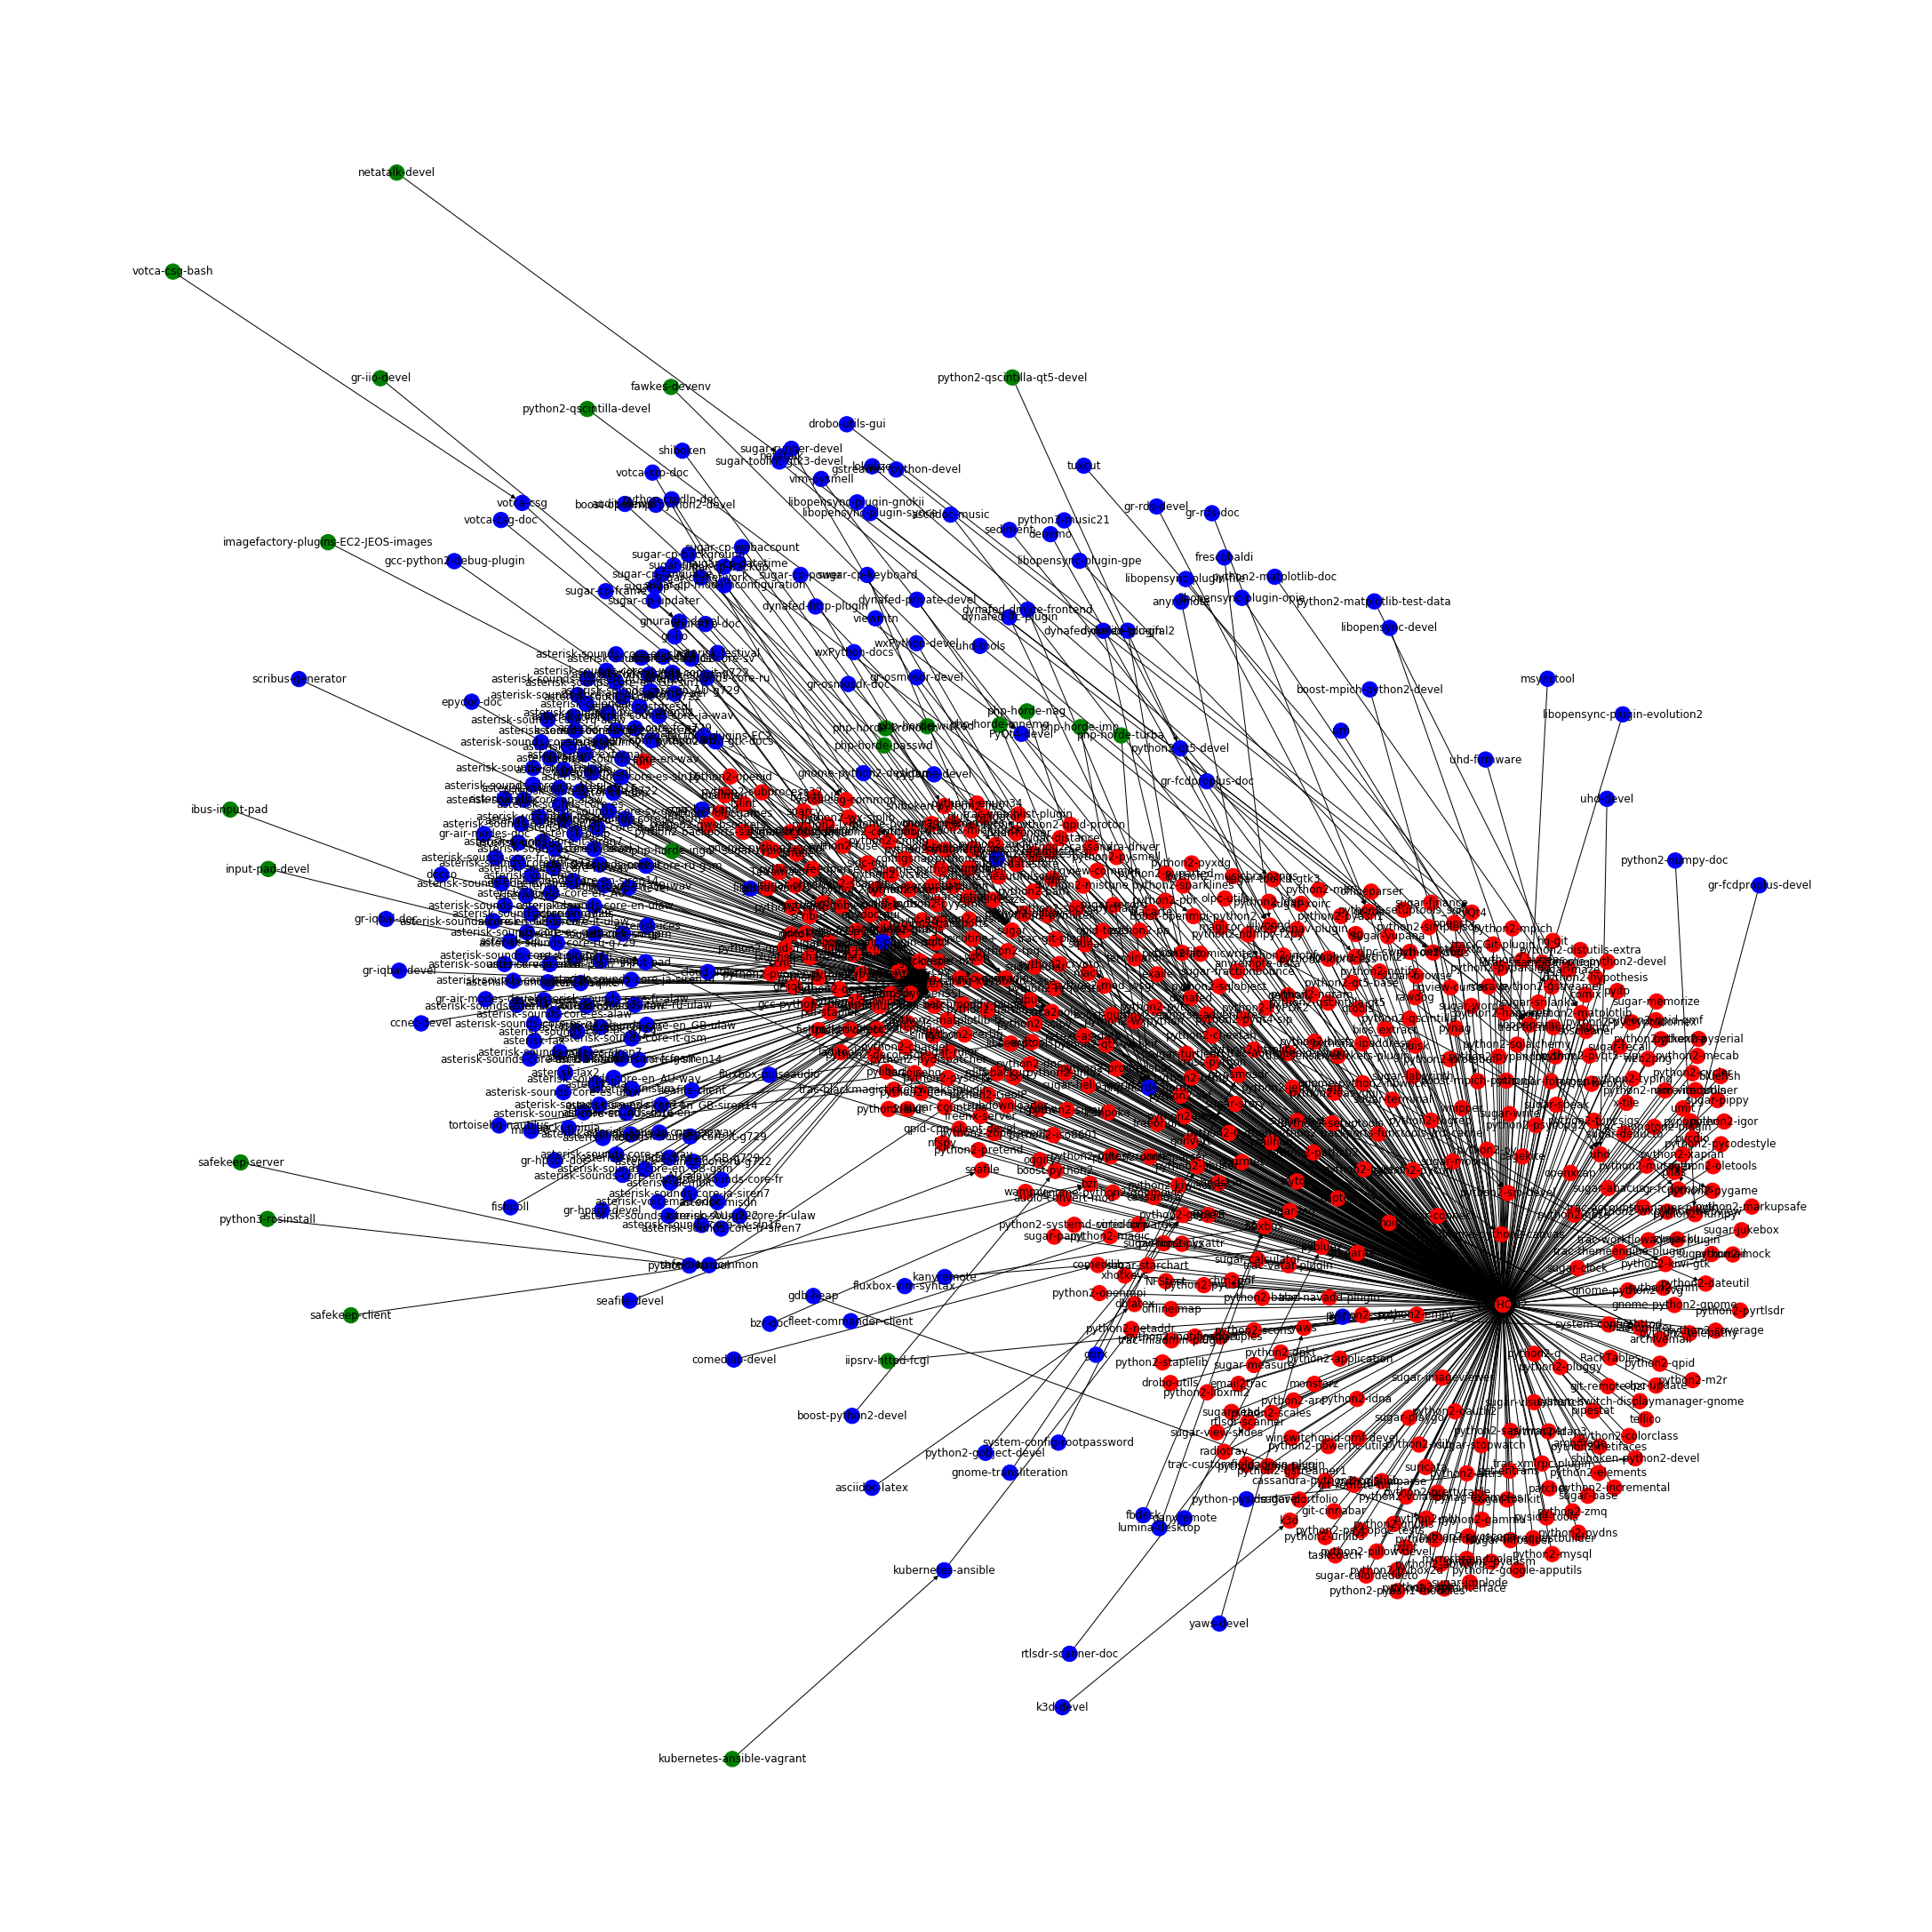

In [27]:
plt_draw(g, node_colors)

## List of packages and theirs paths to Python 2 (including the packages in the first wave)

In [30]:
len(waves)

4

In [31]:
with open("packages.txt", "w") as packages_file:
    binary_packages = list(chain(*[waves[str(n)] for n in waves.keys()]))
    print("Total packages", len(binary_packages))
    for package in sorted(binary_packages):
        path = list(all_simple_paths(g, package, 'PYTHON2'))[0]
        line = f"{package} ({' → '.join(path)})"
        print(line)
        print(line, file=packages_file)

!scp packages.txt fedorapeople.org:/home/fedora/lbalhar/public_html/ >/dev/null

Total packages 760
NFStest (NFStest → PYTHON2)
PyQt4 (PyQt4 → PYTHON2)
PyQt4-devel (PyQt4-devel → python2-sip-devel → PYTHON2)
PyQt4-webkit (PyQt4-webkit → PYTHON2)
PyRTF (PyRTF → PYTHON2)
RackTables (RackTables → PYTHON2)
TeXamator (TeXamator → PYTHON2)
alacarte (alacarte → PYTHON2)
angrydd (angrydd → PYTHON2)
anyremote (anyremote → anyremote-data → PYTHON2)
anyremote-data (anyremote-data → PYTHON2)
archivemail (archivemail → PYTHON2)
archmage (archmage → PYTHON2)
asciidoc-latex (asciidoc-latex → dblatex → PYTHON2)
asciidoc-music (asciidoc-music → lilypond → PYTHON2)
asterisk (asterisk → PYTHON2)
asterisk-ael (asterisk-ael → asterisk → PYTHON2)
asterisk-alembic (asterisk-alembic → asterisk → PYTHON2)
asterisk-alsa (asterisk-alsa → asterisk → PYTHON2)
asterisk-calendar (asterisk-calendar → asterisk → PYTHON2)
asterisk-corosync (asterisk-corosync → asterisk → PYTHON2)
asterisk-curl (asterisk-curl → asterisk → PYTHON2)
asterisk-dahdi (asterisk-dahdi → asterisk → PYTHON2)
asterisk-devel (

## List of all SRPMs and theirs RPMs

In [32]:
inverse_srpm_map = {}
for srpm, pkgs in srpm_mapping.items():
    inverse_srpm_map.update({pkg: srpm for pkg in pkgs})

In [33]:
srpms = defaultdict(list)
for package in binary_packages:
    try:
        srpm = inverse_srpm_map[package]
    except KeyError:
        srpm = "N/A"
    srpms[srpm].append(package)

## List of affected maintainers and their binary RPMs

In [34]:
affected_maintainers = defaultdict(list)
for package in binary_packages:
    try:
        srpm = inverse_srpm_map[package]
    except KeyError:
        srpm = "N/A"
    for maintainer in maintainers.get(srpm, []):
        affected_maintainers[maintainer].append(package)

with open("affected_maintainers.txt", "w") as affected_maintainer_file:
    for maintainer, pkgs in sorted(affected_maintainers.items(), key=lambda x: x[0]):
        line = f"{maintainer} - {', '.join(pkgs)}"
        print(line)
        print(line, file=affected_maintainer_file)

!scp affected_maintainers.txt fedorapeople.org:/home/fedora/lbalhar/public_html/ >/dev/null

aarem - python2-PyPDF2, python2-more-itertools, python2-staplelib, pdf-stapler
abbot - python2-protobuf
abompard - python2-requests, python2-mako, python2-coverage, python2-httplib2, python2-pysocks, python2-urllib3, python2-zope-event
acaringi - cassandra, cassandra-python2-cqlshlib
ajmitchell - NFStest
alexl - gnome-python2-devel, gnome-python2-gnomekeyring, gnome-python2-gnomevfs, gnome-python2-canvas, gnome-python2-gnome, python2-dbus, gnome-python2-libwnck, alacarte, python2-ldap, gnome-python2-gconf, gnome-python2-gtkspell, gnome-python2-rsvg, gnome-python2-desktop
alexlan - dblatex, graphviz-python2, bibus, tellico
alikins - func, certmaster
amitshah - pius
amluto - python2-musicbrainzngs
andreamanzi - dynafed, dynafed-dmlite-frontend, dynafed-dmlite-plugin, dynafed-http-plugin, dynafed-lfc-plugin, dynafed-private-devel, dynafed-tpc-gfal2
anishpatil - gnome-transliteration
ankursinha - python3-wstool
antiaircraft - gst-entrans
anyremote - ganyremote, kanyremote
aperezbios - suga

## Combined structure

In [35]:
structure = defaultdict(lambda: defaultdict(list))
for binary_pkg in binary_packages:
    try:
        srpm = inverse_srpm_map[binary_pkg]
        srpm_maintainers = maintainers[srpm]
    except KeyError:
        srpm = "N/A"
        srpm_maintainers = ["N/A"]
    for maintainer in srpm_maintainers:
        structure[maintainer][srpm].append(binary_pkg)

# Build dependencies (direct)

In [37]:
srpm_dependants = []
for package in sorted(binary_packages):
    build_requires = !dnf --repo=rawhide-source --repo=rawhide repoquery --qf "%{{NAME}} %{{ARCH}}" --whatrequires {package} 2>/dev/null | grep " src$" | cut -d " " -f 1
    print(f"{package} in required in build time by {build_requires}")
    for srpm in build_requires:
        if srpm in srpms.keys() or srpm in srpm_dependants:
            print(f"✅ {srpm} is already in the graph")
            continue
        if srpm in source_exc:
            print(f"✅ {srpm} in in the list of source ackages with exceptions")
            continue
        try:
            rpms = srpm_mapping[srpm]
        except KeyError:
            print(f"Cannot get RPMs for {srpm}")
            continue
        if any([p.startswith("python2-") for p in rpms]):
            print(f"✅ {srpm} provides python2 subpackage - {rpms}")
            continue
        
        srpm_dependants.append(srpm)
        g.add_edge(srpm, package)
        srpm_maintainers = maintainers[srpm]
        for maintainer in srpm_maintainers:
            structure[maintainer][srpm].append("SRPM")  # For these special cases, we'll generate path for SRPM

NFStest in required in build time by []
PyQt4 in required in build time by []
PyQt4-devel in required in build time by ['gnuradio', 'gr-air-modes', 'hgview', 'pilas', 'python-poppler-qt4', 'qscintilla']
✅ gnuradio is already in the graph
✅ gr-air-modes is already in the graph
✅ hgview is already in the graph
✅ pilas is already in the graph
✅ qscintilla is already in the graph
PyQt4-webkit in required in build time by []
PyRTF in required in build time by []
RackTables in required in build time by []
TeXamator in required in build time by []
alacarte in required in build time by []
angrydd in required in build time by []
anyremote in required in build time by []
anyremote-data in required in build time by []
archivemail in required in build time by []
archmage in required in build time by []
asciidoc-latex in required in build time by []
asciidoc-music in required in build time by []
asterisk in required in build time by []
asterisk-ael in required in build time by []
asterisk-alembic i

# Final outputs

## Package structure with paths

In [38]:
for maintainer in sorted(structure.keys()):
    print(maintainer)
    for srpm in structure[maintainer]:
        print(f"  {srpm}")
        for rpm in structure[maintainer][srpm]:
            if rpm == "SRPM":
                path = list(all_simple_paths(g, srpm, 'PYTHON2'))[0]
                line = f"    SRPM (build depenency) ({' → '.join(path)})"
            else:
                path = list(all_simple_paths(g, rpm, 'PYTHON2'))[0]
                line = f"    {rpm} ({' → '.join(path)})"
            print(line)

N/A
  N/A
    olpc-utils (olpc-utils → PYTHON2)
    taskcoach (taskcoach → PYTHON2)
    python2-ipaddress (python2-ipaddress → PYTHON2)
    python2-magic (python2-magic → PYTHON2)
aarem
  python-PyPDF2
    python2-PyPDF2 (python2-PyPDF2 → PYTHON2)
  python2-more-itertools
    python2-more-itertools (python2-more-itertools → PYTHON2)
  pdf-stapler
    python2-staplelib (python2-staplelib → PYTHON2)
    pdf-stapler (pdf-stapler → PYTHON2)
abbot
  protobuf
    python2-protobuf (python2-protobuf → PYTHON2)
abompard
  python-requests
    python2-requests (python2-requests → PYTHON2)
  python-mako
    python2-mako (python2-mako → PYTHON2)
  python-coverage
    python2-coverage (python2-coverage → PYTHON2)
  python-httplib2
    python2-httplib2 (python2-httplib2 → PYTHON2)
  python-pysocks
    python2-pysocks (python2-pysocks → PYTHON2)
  python-urllib3
    python2-urllib3 (python2-urllib3 → PYTHON2)
  python-zope-event
    python2-zope-event (python2-zope-event → PYTHON2)
acaringi
  cassandr

## Recipients

In [39]:
recipients = set(structure.keys())
print(f"Total recipients: {len(recipients)}")
for recipient in recipients:
    print(f"{recipient}@fedoraproject.org")

Total recipients: 381
poros@fedoraproject.org
tuxbrewr@fedoraproject.org
sundaram@fedoraproject.org
cdamian@fedoraproject.org
churchyard@fedoraproject.org
zbyszek@fedoraproject.org
thias@fedoraproject.org
awjb@fedoraproject.org
imcleod@fedoraproject.org
trasher@fedoraproject.org
dmalcolm@fedoraproject.org
ajmitchell@fedoraproject.org
veillard@fedoraproject.org
timn@fedoraproject.org
jujens@fedoraproject.org
brouhaha@fedoraproject.org
alikins@fedoraproject.org
salimma@fedoraproject.org
aruiz@fedoraproject.org
frankcrawford@fedoraproject.org
jamatos@fedoraproject.org
beckerde@fedoraproject.org
tuju@fedoraproject.org
tmraz@fedoraproject.org
ilianaw@fedoraproject.org
praiskup@fedoraproject.org
kevin@fedoraproject.org
msuchy@fedoraproject.org
kkofler@fedoraproject.org
jmlich@fedoraproject.org
vrutkovs@fedoraproject.org
odubaj@fedoraproject.org
cstratak@fedoraproject.org
kwizart@fedoraproject.org
devrim@fedoraproject.org
company@fedoraproject.org
sagarun@fedoraproject.org
linkdupont@fedorapr

## Save

In [40]:
nx.write_adjlist(g, "full_graph.adjlist")